In [141]:
from pymongo import MongoClient
from matplotlib import pyplot as plt
import numpy as np
from dcase2020_task2.data_sets.mcm_dataset import INVERSE_CLASS_MAP, TRAINING_ID_MAP, CLASS_MAP
from scipy.stats import rankdata
import pandas as pd
import json

baseline_auc = { 
    'name': 'baseline',
    0: {0: 0.5441, 2: 0.7340, 4: 0.6161, 6: 0.7392},
    1: {0: 0.6715, 2: 0.6153, 4: 0.8833, 6: 0.7455},
    2: {0: 0.9619, 2: 0.7897, 4: 0.9430, 6: 0.6959},
    3: {1: 0.8136, 2: 0.8597, 3: 0.6330, 4: 0.8445},
    4: {1: 0.7807, 2: 0.6416, 3: 0.7535},
    5: {0: 0.6876, 2: 0.6818, 4: 0.7430, 6: 0.5390}
    }
    
baseline_pauc = {
    'name': 'baseline',
    0: {0: 0.4937, 2: 0.5481, 4: 0.5326, 6: 0.5235},
    1: {0: 0.5674, 2: 0.5810, 4: 0.6710, 6: 0.5802},
    2: {0: 0.8144, 2: 0.6368, 4: 0.7198, 6: 0.4902},
    3: {1: 0.6840, 2: 0.7772, 3: 0.5521, 4: 0.6897},
    4: {1: 0.6425, 2: 0.5601, 3: 0.6103},
    5: {0: 0.5170, 2: 0.5183, 4: 0.5197, 6: 0.4843}
}

global result

def get_experiment(runs, name, metric='auroc_mean'):
    experiment_dict = dict()
    for i in range(6):
        experiment_dict[i] = dict()
    
    experiment_dict['name'] = name
    experiment_dict['metric'] = metric
    if metric == 'auroc_mean':
        metirc_idx = 0
    elif metric == 'pauroc_mean':
        metirc_idx = 1
    elif metric == 'auroc_max':
        metirc_idx = 2
    elif metric == 'pauroc_max':
        metirc_idx = 3
    else:
        raise AttributeError
    
    for experiment in runs:
        if experiment['config'].get('descriptor') == name:
            machine_dict = experiment_dict.get(experiment['config']['machine_type'])
            result = experiment.get('result')
            machine_type = INVERSE_CLASS_MAP[experiment['config']['machine_type']]
            machine_id = experiment['config']['machine_id']
            
            if result:
                machine_dict[experiment['config']['machine_id']] = result.get(
                    machine_type, {}
                ).get(
                    f'json://{machine_id}', -1
                )['py/tuple'][metirc_idx]
            else:
                machine_dict[experiment['config']['machine_id']] = 0
    return experiment_dict


def get_record(experiment):
    record = [experiment['name']]
    for i in range(6):
        for j in TRAINING_ID_MAP[i]:
                v = experiment.get(i)
                if v:
                    v = v.get(j, 1)
                else:
                    v = 1
                record.append(v)
    assert len(record) == 24
    return  record

In [142]:
client = MongoClient('mongodb://student2.cp.jku.at:27017/')
#experiments_made = [r for r in client.dcase2020_2_madog.runs.find({"experiment.name": "dcase2020_task2_BaselineExperiment"})]
experiments = [r for r in client.dcase2020_task2_ae_baseline_gridsearch.runs.find({"experiment.name": "dcase2020_task2_BaselineExperiment"})]

In [143]:
descriptors = set()
for experiment in experiments:
    descriptors = descriptors.union(set([experiment['config']['descriptor']]))
len(descriptors)

64

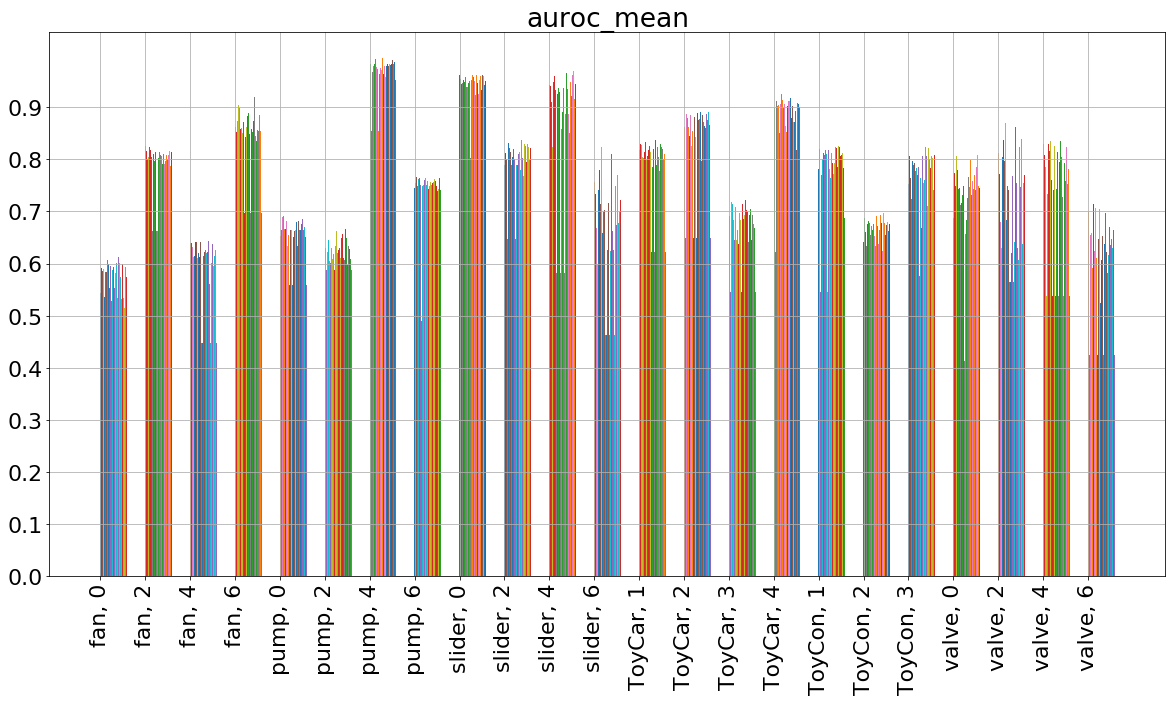

In [193]:
metric = 'auroc_mean'
bar_width = 0.6
bar_spacing=0.00

data = [get_record(baseline_auc)]

for descriptor in descriptors:
    data.append(
        get_record(
            get_experiment(
                experiments, 
                descriptor, 
                metric=metric
            )
        )
    )

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.title(f'{metric}')
labels = []
for i in range(6):
    for j in TRAINING_ID_MAP[i]:
        labels.append("{}, {}".format(INVERSE_CLASS_MAP[i][:6], j))

for i, d in enumerate(data):
    plt.bar(
        np.arange(len(labels)) + i * (bar_width / len(data) + bar_spacing), 
        d[1:],
        bar_width/ len(data),
        label=d[0]
    )

plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
plt.yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.savefig('auc.png')
plt.show()


data = list(zip(*data))
names = data[0]
data = np.array(data[1:]).T

data.shape

In [197]:
auc_ranks = []
idxes = [0, 4, 8, 12, 16, 19, 23]
for i, j in zip(idxes[:-1], idxes[1:]):
    
    average_auc = data[:, i:j].mean(axis=1)
    auc_ranks.append(rankdata(-average_auc))
    
auc_ranks = np.array(list(zip(*auc_ranks)))
average_auc_ranks = auc_ranks.mean(axis=1)

In [211]:
indices = list(np.argsort(average_auc_ranks))
names = np.array(names)

for i, (n, j) in enumerate(zip(names[indices], indices)):
    print(f'{i}: ID-{j} {n}')


0: ID-48 BaselineExperiment_Model:[dcase2020_task2.models.AE_512_3_64]_Training:[512_0.001_1e-05]_Features:[True_128_5_1024_512_2.0_0]_1220
1: ID-3 BaselineExperiment_Model:[dcase2020_task2.models.AE_512_3_32]_Training:[512_0.001_1e-05]_Features:[True_128_5_1024_512_2.0_0]_1220
2: ID-44 BaselineExperiment_Model:[dcase2020_task2.models.AE_1024_3_64]_Training:[512_0.001_1e-05]_Features:[True_128_5_1024_512_2.0_0]_1220
3: ID-50 BaselineExperiment_Model:[dcase2020_task2.models.AE_1024_2_64]_Training:[512_0.001_1e-05]_Features:[True_128_5_1024_512_2.0_0]_1220
4: ID-15 BaselineExperiment_Model:[dcase2020_task2.models.AE_512_2_64]_Training:[512_0.001_0]_Features:[True_128_5_1024_512_2.0_0]_1220
5: ID-13 BaselineExperiment_Model:[dcase2020_task2.models.AE_512_2_64]_Training:[512_0.001_1e-05]_Features:[True_128_5_1024_512_2.0_0]_1220
6: ID-28 BaselineExperiment_Model:[dcase2020_task2.models.AE_512_2_32]_Training:[512_0.001_1e-05]_Features:[True_128_5_1024_512_2.0_0]_1220
7: ID-1 BaselineExperim

In [215]:
print(data[64,:] - data[0,:])

[-0.01645872 -0.07232869 -0.16923218 -0.04208089 -0.11240909 -0.02737207
 -0.0285     -0.2550098  -0.15934382 -0.14337041 -0.36041573 -0.23297865
 -0.19243117 -0.21126873 -0.08826685 -0.22278571 -0.23566406 -0.09352958
 -0.17816463 -0.27533109 -0.11755    -0.20491667 -0.11475   ]
